In [167]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='html5')

In [168]:
# Classes

class Func:
    def __init__(self, func, pars):
        self.func = func
        self.pars = pars
    def __call__(self, *args):
        return self.func(*args, *self.pars)

class U_func:
    def __init__(self, main, inits, null, setting):
        self.null = null
        self.main = main
        self.init_t = inits[0]
        self.init_r = inits[1]
        self.setting = setting
    def __call__(self, F, *args):
        standart_border = self.setting.standart_border
        t_left = self.setting.t_left - 1
        t_right = self.setting.t_right
        r_left = self.setting.r_left
        r_right = self.setting.r_right
        

        t, r = args[0], args[1:len(args)]
        if t==t_left:
            return self.init_t(*r)
        
        i = 0
        for x_i in r:
            if standart_border:
                if x_i==r_left[i]:
                    return self.init_r(t)
            else:
                if x_i==r_right[i]:
                    return self.init_r(t)
            i+=1

        if (t>=t_right):
            return self.null(F, t, *r)
        
        i = 0
        for x_i in r:
            if (x_i>=r_right[i]):
                return self.null(F, t, *r)
            i+=1

        for x_i in r:
            return self.main(F, t, *r)
        
class Setting:
    def __init__(self, standart_border=True, borders_t = (0,0), borders_r = (0,0)):
        self.standart_border = standart_border
        self.t_left = borders_t[0]
        self.t_right = borders_t[1]
        self.r_left = borders_r[0::2]
        self.r_right = borders_r[1::2]

class Solver:
    def __init__(self, N = 500, M = 50, rng_x = (0,1.0), rng_t = (0, 1.0), name="name"):
        self.name = name
        self.N, self.M = N, M
        self.rng_x = rng_x
        self.rng_t = rng_t

        # spatial domain
        xmin, xmax = rng_x
        tmin, tmax = rng_t
        self.xmin, self.xmax = xmin, xmax
        self.tmin, self.tmax = tmin, tmax

        # x grid of n points
        self.X, self.dx = np.linspace(xmin,xmax,M,retstep=True)
        self.T, self.dt = np.linspace(tmin,tmax,N,retstep=True)

        # each value of the U array contains the solution for all x values at each timestep
        self.U = np.zeros((N, M))

    # explicit euler solution
    def equation(self, funcs, pars, dt=(0,0), dr=(0,0), invert=False):
        u_main, init_t, init_r, equal = funcs
        par_main, par_init_t, par_init_r = pars

        init_t_func = Func(init_t, par_init_t)
        init_r_func = Func(init_r, par_init_r)
        init_func = (init_t_func, init_r_func)
        equal_func = Func(equal, ())

        par_main = self.dt, self.dx, *par_main
        main_func = Func(u_main, par_main)

        dt_left, dt_right = dt[0], dt[1]
        dr_left, dr_right = dr[0], dr[1]

        setting = Setting(standart_border=not(invert), 
                          borders_t=(0+dt_left,self.N + dt_right), 
                          borders_r=(0+dr_left,self.M + dr_right))

        u_scheme = U_func(main_func, init_func, equal_func, setting=setting)
        for t in range(self.N):
            if invert:
                rng_r = range(self.M-1,-1,-1)
            else:
                rng_r = range(self.M)

            for r in rng_r:
                self.U[t,r] = u_scheme(self.U, t-1, r)
        return self.U, self.X, self.T

class Printer:
    def __init__(self, name="name", xlim=[0,1], ylim=[-2,2]):
        self.name = name
        self.xlim = xlim
        self.ylim = ylim
        
    def animate(self, X, U, Y=np.array([]), G=np.array([])):
        # plot solution
        plt.style.use('dark_background')
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)

        # animate the time data
        def animate_graph(i):
            ax1.clear()
            if G.size!=0:
                x0 = G[i]
                X0 = Y[i]
                plt.plot(X0,x0,color='deepskyblue') #or 'blue' or 'aqua'

            x = U[i]
            plt.plot(X,x,color='lime')

            plt.grid(True)
            plt.ylim(self.ylim)
            plt.xlim(self.xlim)

        anim = animation.FuncAnimation(fig,animate_graph,frames=len(U),interval=20)
        plt.xlim(self.xlim)
        return anim


In [169]:
# Functions

def real_sol(X, T, c, u_0, u_1):
    N = T.size
    T_full = T[-1] - T[0]
    G = np.zeros((N, 4))
    Y = np.zeros((N, 4))
    for t in range(N):
        G[t,0], Y[t,0] = u_1, X[0]
        if c>0:
            G[t,0], Y[t,0] = u_1, X[0]
            G[t,1], Y[t,1] = u_1, c * (t/N * T_full)
            G[t,2], Y[t,2] = u_0, c * (t/N * T_full)
            G[t,3], Y[t,3] = u_0, X[-1]
        else:
            G[t,0], Y[t,0] = u_0, X[0]
            G[t,1], Y[t,1] = u_0, X[-1] + c * (t/N * T_full)
            G[t,2], Y[t,2] = u_1, X[-1] + c * (t/N * T_full)
            G[t,3], Y[t,3] = u_1, X[-1]
    return G, Y

def equal(F, t, x):
    return F[t, x]

def phi(x, u_0, u_1, point=0):
    return u_1 if x==point else u_0

def psi(t, u_1):
    return u_1

def phi_m(r_m):
    if r_m>1:
        return min(2, r_m)
    elif (r_m>0 and r_m<=1):
        return min(1, 2*r_m)
    else:
        return 0

In [170]:
# Constants
N, M = 300, 200
c = 2.0
q = 0.25

U0, U1 = 5.0, 10.0

L = 1.0
T = abs(L / c)

In [171]:
# Printer
printer = Printer(name="first", xlim=[0,L], ylim=[U0-1,U1+1])

_Good solution with 0 < $\sigma$ < 1 (N!=M)_

In [123]:
N, M = 300, 200
c = 2.0
q = 0.25
solver = Solver(name="test", N = N, M = M, rng_x = (0,L), rng_t = (0, T))

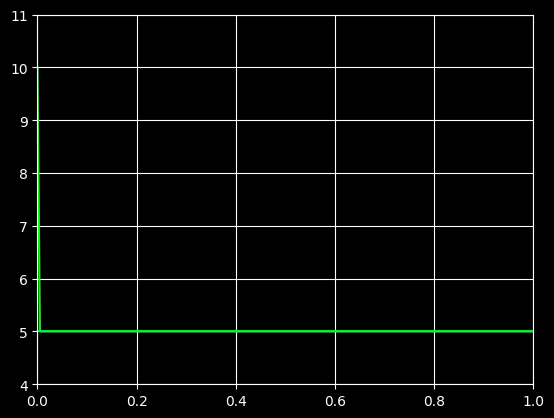

In [90]:
# GOOD
# Scheme_1
def scheme_1(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    return F[t,x] - sigma * (F[t,x] - F[t,x-1])

funcs = scheme_1, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,0)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)
animation = printer.animate(X, U, Y=Y_real, G=G_real)
animation

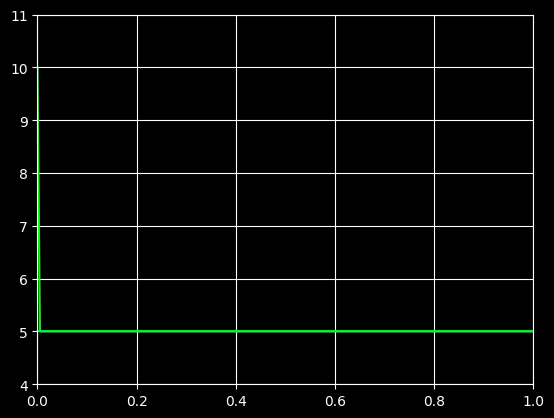

In [100]:
# GOOD
# Scheme_2
def scheme_2(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    return (F[t,x] + sigma * F[t+1,x-1]) / (1 + sigma)

funcs = scheme_2, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,0)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

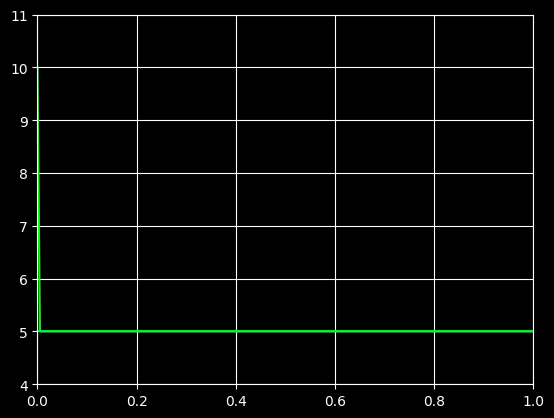

In [107]:
# GOOD
# Scheme_4
def scheme_4(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    return 0.5 * ( (F[t,x-1] + F[t, x+1]) - sigma * (F[t, x+1] - F[t,x-1]) )

funcs = scheme_4, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,-1)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

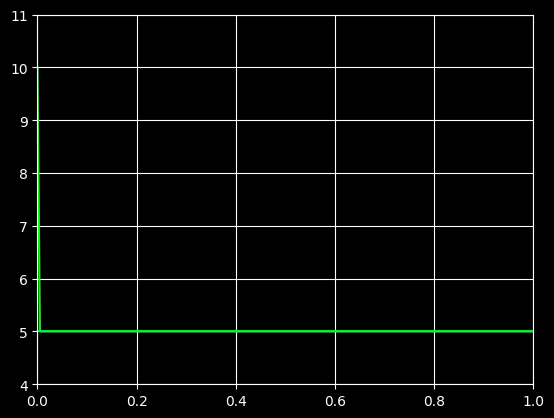

In [114]:
# GOOD
# Scheme_5
def scheme_5(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    y_pos = 0.5 * sigma * (1 - sigma) * (F[t,x+1] - F[t,x])
    y_neg = 0.5 * sigma * (1 - sigma) * (F[t,x] - F[t,x-1])

    return F[t,x] - sigma * (F[t,x] - F[t,x-1]) - (y_pos - y_neg)

funcs = scheme_5, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,-1)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

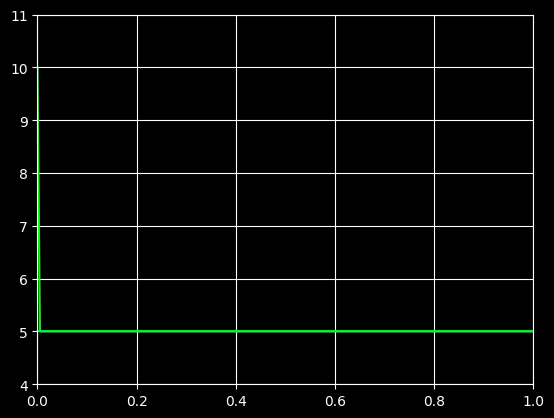

In [124]:
# GOOD
# Scheme_5_sm

q = 0.15 # best result

def scheme_5(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    y_pos = 0.5 * sigma * (1 - sigma) * (F[t,x+1] - F[t,x])
    y_neg = 0.5 * sigma * (1 - sigma) * (F[t,x] - F[t,x-1])

    return F[t,x] - sigma * (F[t,x] - F[t,x-1]) - (y_pos - y_neg)

def scheme_5_sm(F, t, x, dt, dx, a, q):
    sigma = a*dt/dx
    Dpp = F[t,x+2] - F[t,x+1]
    Dp = F[t,x+1] - F[t,x]
    Dm = F[t,x] - F[t,x-1]
    Dmm = F[t,x-1] - F[t,x-2]

    Q_pos, Q_neg = 0, 0

    if (Dpp*Dp < 0) or (Dp * Dm < 0):
        Q_pos = Dp

    if (Dmm*Dm < 0) or (Dp * Dm < 0):
        Q_neg = Dm

    return scheme_5(F, t, x, dt, dx, a) + q * (Q_pos - Q_neg)

funcs = scheme_5_sm, phi, psi, equal
pars = ((c,q), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,-2)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

_Good solution with -1 < $\sigma$ < 0 (N!=M, c<0)_

In [131]:
solver = Solver(name="test", N = N, M = M, rng_x = (0,L), rng_t = (0, T))
N, M = 300, 200
c = -2.0

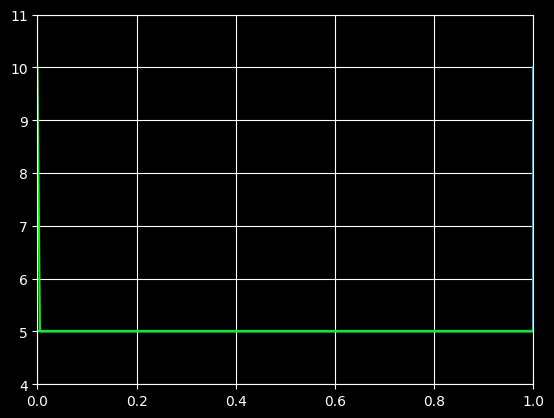

In [132]:
# GOOD
# Scheme_3

def scheme_3(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    return (F[t,x] - sigma * F[t+1,x+1]) / (1 - sigma)

funcs = scheme_3, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r, invert = (0,0), (0,-1), True

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r, invert=invert)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

_Good solution with $\sigma$=1 (N=M)_

In [162]:
N, M = 500, 500
c = 2.0
solver = Solver(name="test", N = N, M = M, rng_x = (0,L), rng_t = (0, T))

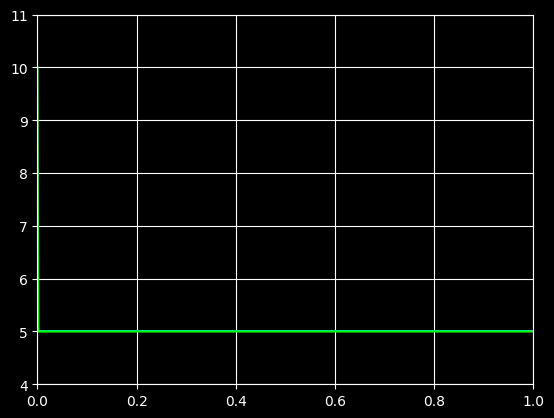

In [149]:
# GOOD
# Scheme_6

def scheme_6(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    return (F[t,x] - sigma * (1.5 * F[t,x] - 2 * F[t,x-1] + 0.5 * F[t,x-2]) 
                     + 0.5 * sigma**2 * (F[t,x] - 2 * F[t,x-1] + F[t,x-2]))

funcs = scheme_6, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,-1)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

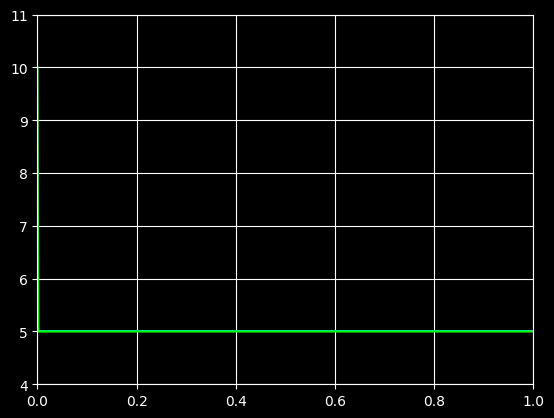

In [156]:
# GOOD
# Scheme_7

eps = 1e-15
def scheme_7(F, t, x, dt, dx, a, eps):
    sigma = a*dt/dx

    r_m = (F[t,x] - F[t,x-1] + eps)/(F[t,x+1] - F[t,x] + eps)

    y_pos = 0.5 * phi_m(r_m) * sigma * (1 - sigma) * (F[t,x+1] - F[t,x])
    y_neg = 0.5 * phi_m(r_m) * sigma * (1 - sigma) * (F[t,x] - F[t,x-1])

    return F[t,x] - sigma * (F[t,x] - F[t,x-1]) - (y_pos - y_neg)

funcs = scheme_7, phi, psi, equal
pars = ((c,eps), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,-1)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

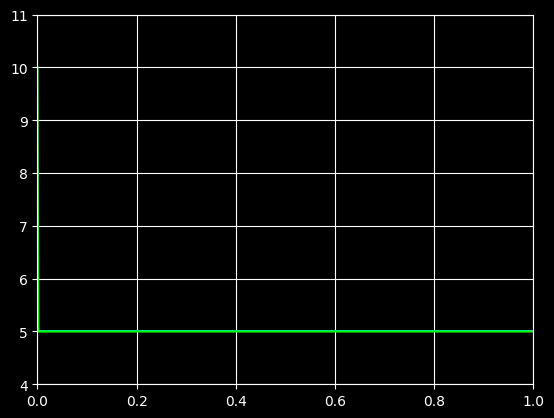

In [163]:
# GOOD
# Scheme_8

def scheme_8(F, t, x, dt, dx, a):
    sigma = a*dt/dx

    def S(sigma, a, b):
        return 0.5*(1+sigma)*a + 0.5*(1-sigma)*b
    def N(sigma, a, b):
        return 0.5*(3-sigma)*a - 0.5*(1-sigma)*b

    if np.abs(F[t,x+1] - F[t,x]) >= np.abs(F[t,x] - F[t,x-1]):
        y_pos = N(sigma, F[t,x], F[t,x-1])
    else:
        y_pos = S(sigma, F[t,x], F[t,x+1])

    if np.abs(F[t,x] - F[t,x-1]) >= np.abs(F[t,x-1] - F[t,x-2]):
        y_neg = N(sigma, F[t,x-1], F[t,x-2])
    else:
        y_neg = S(sigma, F[t,x-1], F[t,x])

    return F[t,x] - sigma * (y_pos - y_neg)

funcs = scheme_8, phi, psi, equal
pars = ((c,), (U0, U1,), (U1,))
borders_t, borders_r = (0,0), (0,-1)

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r)
G_real, Y_real = real_sol(X, T, c, U0, U1)

printer.animate(X, U, Y=Y_real, G=G_real)

__Решение задачи для уравнения (2) с помощью схемы (1)__

_Unlinear equation_


In [172]:
N, M = 500, 200
c = - 0.5
solver = Solver(name="test", N = N, M = M, rng_x = (0,L), rng_t = (0, T))

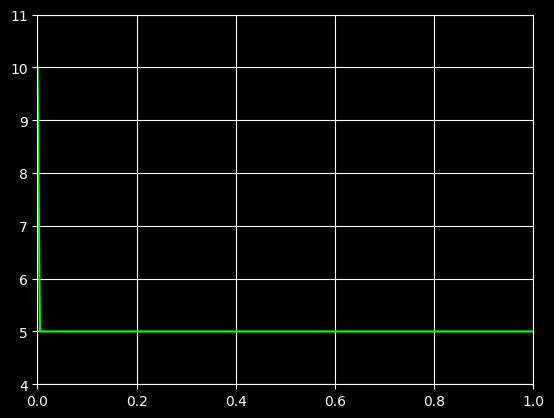

In [173]:
# SO-SO
# Unlinear scheme

def scheme_uu(F, t, x, dt, dx, a):
    eta = a*dt/dx
    return + eta * F[t,x]*F[t,x] + F[t,x] * (1 - eta * F[t,x-1])

funcs = scheme_uu, phi, psi, equal
pars = ((c,), (U0, U1, ), (U1,))
borders_t, borders_r, invert = (0,0), (0,0), False

U, X, T = solver.equation(funcs=funcs, pars=pars, dt=borders_t, dr=borders_r ,invert=invert)
printer.animate(X, U)